# Neural net ensemble for sax
### Step 3
### Load models from disk, predict and give results 

In [32]:
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model, Sequential
from keras.metrics import AUC, Recall
from keras.layers import Dense, Dropout
from keras.metrics import Recall
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [3]:
from _all_saxes import x_train, x_test, y_train, y_test
# ^ This will take some time...

In [4]:
dependencies = {
    'recall': Recall
}

models = []
for fn in glob.glob('./keras_models/model_sax_*'):
    # See: https://www.tensorflow.org/guide/keras/save_and_serialize
    # See: https://stackoverflow.com/questions/51700351
    # See: https://github.com/keras-team/keras/issues/10104
    # See: https://stackoverflow.com/questions/61513447 << use compile=False kw param
    loaded = load_model(fn, custom_objects=dependencies, compile=False)
    models.append(loaded)

In [5]:
raw_values = models[0].predict(x_test)
for model in models[1:]:
    raw_values  = np.hstack((raw_values, model.predict(x_test)))

In [6]:
y_pred = [1 if x >= 0.5 else 0 for x in raw_values.mean(1)]
y_pred = np.asarray(y_pred)  # should be same shape as y_test

In [7]:
c_matrix = confusion_matrix(y_test, y_pred)
idx = cols = [0, 1]
pd.DataFrame(c_matrix, index=idx, columns=cols)

,0,1
0,360,95
1,65,600


In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       455
           1       0.86      0.90      0.88       665

    accuracy                           0.86      1120
   macro avg       0.86      0.85      0.85      1120
weighted avg       0.86      0.86      0.86      1120



In [10]:
raw_values.shape

(1120, 54)

In [11]:
x_train.shape

(4477, 32)

In [12]:
x_test.shape

(1120, 32)

In [13]:
stack_train = models[0].predict(x_train)
for model in models[1:]:
    stack_train = np.hstack((stack_train, model.predict(x_train)))

(4477, 54)

In [17]:
stack_test = models[0].predict(x_test)
for model in models[1:]:
    stack_test = np.hstack((stack_test, model.predict(x_test)))

In [23]:
model = Sequential()
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall()])
history = model.fit(stack_train, y_train, epochs=40, batch_size=32, 
                    validation_split=0.2)


Train on 3581 samples, validate on 896 samples
Epoch 1/40
3581/3581 [==============================] - 2s 557us/step - loss: 0.5326 - recall_4: 0.9325 - val_loss: 0.4992 - val_recall_4: 0.9946
Epoch 2/40
3581/3581 [==============================] - 1s 148us/step - loss: 0.4180 - recall_4: 0.9784 - val_loss: 0.4132 - val_recall_4: 0.9565
Epoch 3/40
3581/3581 [==============================] - 1s 156us/step - loss: 0.2988 - recall_4: 0.9531 - val_loss: 0.3663 - val_recall_4: 0.9366
Epoch 4/40
3581/3581 [==============================] - 1s 142us/step - loss: 0.2488 - recall_4: 0.9444 - val_loss: 0.3560 - val_recall_4: 0.9167
Epoch 5/40
3581/3581 [==============================] - 1s 156us/step - loss: 0.2155 - recall_4: 0.9463 - val_loss: 0.3675 - val_recall_4: 0.9058
Epoch 6/40
3581/3581 [==============================] - 1s 148us/step - loss: 0.2043 - recall_4: 0.9486 - val_loss: 0.3707 - val_recall_4: 0.8913
Epoch 7/40
3581/3581 [==============================] - 1s 147us/step - loss:

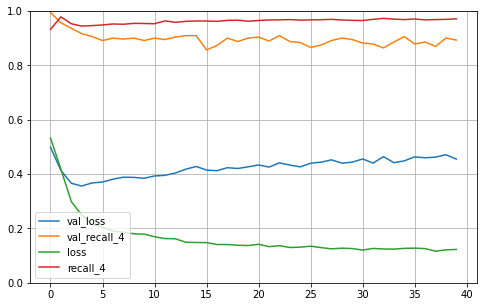

In [24]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


In [27]:
clf = SVC()
clf.fit(stack_train, y_train)
y_pred = clf.predict(stack_test)
print(clf.score(stack_test, y_test))

0.8651785714285715


In [28]:
c_matrix = confusion_matrix(y_test, y_pred)
idx = cols = [0, 1]
pd.DataFrame(c_matrix, index=idx, columns=cols)

,0,1
0,375,80
1,71,594


In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       455
           1       0.88      0.89      0.89       665

    accuracy                           0.87      1120
   macro avg       0.86      0.86      0.86      1120
weighted avg       0.86      0.87      0.86      1120



In [34]:
model_params = {
    'C': uniform(0.1, 4.0)
}

# RandomizedSearchCV(estimator, param_distributions, *, n_iter=10, 
#                    scoring=None, n_jobs=None, iid='deprecated', 
#                    refit=True, cv=None, verbose=0, 
#                    pre_dispatch='2*n_jobs', random_state=None, 
#                    error_score=nan, return_train_score=False)
svm_model = SVC()
clf = RandomizedSearchCV(svm_model, model_params, n_iter=10, cv=5)
model = clf.fit(stack_train, y_train)
params = model.best_estimator_.get_params()

In [37]:
clf = SVC(C=params['C'])
clf.fit(stack_train, y_train)
y_pred = clf.predict(stack_test)
print(clf.score(stack_test, y_test))

0.8660714285714286


In [38]:
c_matrix = confusion_matrix(y_test, y_pred)
idx = cols = [0, 1]
pd.DataFrame(c_matrix, index=idx, columns=cols)

,0,1
0,373,82
1,68,597


In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83       455
           1       0.88      0.90      0.89       665

    accuracy                           0.87      1120
   macro avg       0.86      0.86      0.86      1120
weighted avg       0.87      0.87      0.87      1120

